# Openseespy : An introduction 

In [11]:
!pip install openseespy

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import openseespy.opensees as ops
from mpl_toolkits.mplot3d import Axes3D

## Setup

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class Node: 
    def __init__(self, id, x, y, z):
        self.id = id
        self.x = x
        self.y = y
        self.z = z
    def coords(self):
        return np.array([self.x, self.y, self.z])

class Element:
    def __init__(self, id, node_i, node_j, area, E):
        self.id = id
        self.node_i = node_i
        self.node_j = node_j
        self.area = area
        self.E = E
    def length(self):
        return np.linalg.norm(self.node_j.coords() - self.node_i.coords())
    def direction_cosines(self):
        L = self.length()
        dx = (self.node_j.x - self.node_i.x) / L
        dy = (self.node_j.y - self.node_i.y) / L
        dz = (self.node_j.z - self.node_i.z) / L
        return np.array([dx, dy, dz])

class BuildingModel:
    def __init__(self):
        self.nodes = []
        self.elements = []
        self.mode = "2D"

    def add_node(self, x, y, z):
        self.nodes.append(Node(len(self.nodes), x, y, z))

    def add_element(self, node_i_id, node_j_id, area, E):
        node_i = self.nodes[node_i_id]
        node_j = self.nodes[node_j_id]
        self.elements.append(Element(len(self.elements), node_i, node_j, area, E))

    def plot(self):
        if self.mode == "2D":
            fig, ax = plt.subplots()

            for e in self.elements:
                x = [e.node_i.x, e.node_j.x]
                z = [e.node_i.z, e.node_j.z]
                ax.plot(x, z, 'b-')

            ax.set_xlabel("x")
            ax.set_ylabel("z")
            #ax.set_aspect("equal", adjustable="box")
            plt.show()

        elif self.mode == "3D":
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')

            for e in self.elements:
                ax.plot(
                    [e.node_i.x, e.node_j.x],
                    [e.node_i.y, e.node_j.y],
                    [e.node_i.z, e.node_j.z],
                    'b-'
                )

            ax.set_xlabel("x")
            ax.set_ylabel("y")
            ax.set_zlabel("z")

            plt.show()


    def generate_regular_building(self, m, n, dx=1.0, dy=3.0, dz=3.0, mode="2D", A=1.0, E=1.0):
        self.nodes = []
        self.elements = []
        self.mode = mode

        if mode == "2D":
            # --- Création des noeuds (z inversé) ---
            for floor in range(n):
                for i in range(m):
                    self.add_node(i * dx, 0, floor * dz)

            # --- Colonnes verticales ---
            for floor in range(n - 1):
                base = floor * m
                next_base = (floor + 1) * m
                for i in range(m):
                    self.add_element(base + i, next_base + i, A, E)

            # --- Poutres horizontales ---
            for floor in range(n):
                base = floor * m
                for i in range(m - 1):
                    self.add_element(base + i, base + i + 1, A, E)


        elif mode == "3D":
            for floor in range(n):
                for ix in range(m):
                    for iy in range(m):
                        self.add_node(ix * dx, iy * dx, floor * dy)

            per_floor = m * m

            for floor in range(n - 1):
                base = floor * per_floor
                next_base = (floor + 1) * per_floor
                for k in range(per_floor):
                    self.add_element(base + k, next_base + k, A, E)

            for floor in range(n):
                base = floor * per_floor
                for ix in range(m - 1):
                    for iy in range(m):
                        n1 = base + ix * m + iy
                        n2 = base + (ix + 1) * m + iy
                        self.add_element(n1, n2, A, E)

                for ix in range(m):
                    for iy in range(m - 1):
                        n1 = base + ix * m + iy
                        n2 = base + ix * m + (iy + 1)
                        self.add_element(n1, n2, A, E)


### Motifs : Are defined here in a generic form and can be adpated 


## 2D Structure anlaysis : (n,m) bulding  

In [23]:
motifs = {}

class Motif:
    def __init__(self, local_nodes, edges):
        self.local_nodes = local_nodes
        self.edges = edges

    def can_apply(self, model, origin_node_id, dx, dy, dz):
        return True

    def apply_to_model(self, model, origin_node_id, dx, dy, dz, area, E):
        origin = model.nodes[origin_node_id]
        base_x, base_y, base_z = origin.x, origin.y, origin.z

        coords = []
        for (lx, ly, lz) in self.local_nodes:
            x = base_x + lx*dx
            y = base_y + ly*dy
            z = base_z + lz*dz
            coords.append((x, y, z))

        id_map = {}
        for i, (x, y, z) in enumerate(coords):
            found = None
            for node in model.nodes:
                if abs(node.x-x)<1e-6 and abs(node.y-y)<1e-6 and abs(node.z-z)<1e-6:
                    found = node.id
                    break
            if found is None:
                model.add_node(x, y, z)
                found = model.nodes[-1].id
            id_map[i] = found

        for (i, j) in self.edges:
            ni, nj = id_map[i], id_map[j]
            exists = False
            for e in model.elements:
                if (e.node_i.id==ni and e.node_j.id==nj) or (e.node_i.id==nj and e.node_j.id==ni):
                    exists = True
                    break
            if not exists:
                model.add_element(ni, nj, area, E)


In [24]:
motifs["square_2D"] = Motif(
    local_nodes=[(0,0,0),(1,0,0),(1,0,1),(0,0,1)],
    edges=[(0,1),(1,2),(2,3),(3,0)]
)

motifs["square_2D_diag1"] = Motif(
    local_nodes=[(0,0,0),(1,0,0),(1,0,1),(0,0,1)],
    edges=[(0,1),(1,2),(2,3),(3,0),(0,2)]
)

motifs["square_2D_diag2"] = Motif(
    local_nodes=[
        (0,0,0),   # (x, y, z) mais en 2D y=0 toujours
        (1,0,0),
        (1,0,1),
        (0,0,1)
    ],
    edges=[
        (0,1),(1,2),(2,3),(3,0),
        (1,3)   # diagonale corrigée en 2D (x-z plane)
    ]
)


motifs["vertical_col"] = Motif(
    local_nodes=[(0,0,0),(0,0,1)],
    edges=[(0,1)]
)

motifs["horizontal_beam_x"] = Motif(
    local_nodes=[(0,0,0),(1,0,0)],
    edges=[(0,1)]
)

motifs["horizontal_beam_z"] = Motif(
    local_nodes=[(0,0,0),(0,0,1)],
    edges=[(0,1)]
)
motifs["cube_3D"] = Motif(
    local_nodes=[
        (0,0,0),(1,0,0),(1,1,0),(0,1,0),
        (0,0,1),(1,0,1),(1,1,1),(0,1,1)
    ],
    edges=[
        (0,1),(1,2),(2,3),(3,0),
        (4,5),(5,6),(6,7),(7,4),
        (0,4),(1,5),(2,6),(3,7)
    ]
)

motifs["cube_3D_diag"] = Motif(
    local_nodes=[
        (0,0,0),(1,0,0),(1,1,0),(0,1,0),
        (0,0,1),(1,0,1),(1,1,1),(0,1,1)
    ],
    edges=[
        (0,1),(1,2),(2,3),(3,0),
        (4,5),(5,6),(6,7),(7,4),
        (0,4),(1,5),(2,6),(3,7),
        (0,6)
    ]
)



True


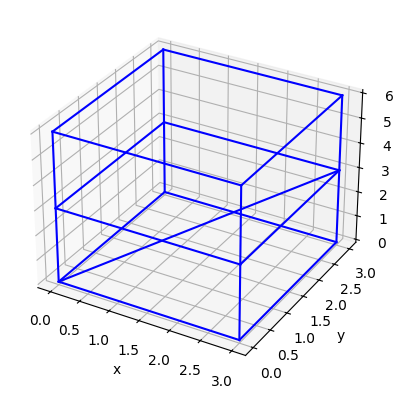

In [28]:
# 1. Créer le modèle de bâtiment
model = BuildingModel()

model.generate_regular_building(
    m=2,       # 4 nodes par étage
    n=3,       # 4 étages
    dx=3, dy=3, dz=3,
    mode="3D",
    A=0.02, E=2e11
)

# 2. Origine correcte pour appliquer le motif (carré 2D en bas-gauche)
origin = 0   # node (0,0,0)

print(motifs["cube_3D_diag"].can_apply(model, 0, dx=3, dy=3, dz=3))
motifs["cube_3D_diag"].apply_to_model(model, 0, dx=3, dy=3, dz=3, area=0.02, E=2e11)
model.plot()

